# Library

In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import koreanize_matplotlib


# Baseline 모델 비교

In [28]:
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/base/train_label.csv"
train = "./data/base/train_merged.csv"
test_label = "./data/base/test_label.csv"
test = "./data/base/test_merged.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train)
test_df = load_sleep_data(test_label, test)

# Stratify용 라벨 (CN, MCI, Dem → 0, 1, 2)
stratify_label = train_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 2}).values
groups = train_df["EMAIL"].values

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').columns.tolist()
substrings_to_remove = ['Unnamed: 0']
numeric_cols = [col for col in numeric_cols if not any(col in sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 1. 모델 정의
# -------------------------
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "LinearSVM": LinearSVC(random_state=42, max_iter=10000)
}

# -------------------------
# 2. 결과 저장 및 CV 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
results = []
feature_importance_all = {}

for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    total_cm = np.zeros((2, 2), dtype=int)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, stratify_label, groups)):
        X_train_fold = X_scaled[train_idx]
        X_val_fold = X_scaled[val_idx]

        # MCI + Dem = 1, CN = 0
        y_train_fold = train_df.iloc[train_idx]["DIAG_NM"].map(lambda x: 1 if x in ["MCI", "Dem"] else 0).values
        y_val_fold = train_df.iloc[val_idx]["DIAG_NM"].map(lambda x: 1 if x in ["MCI", "Dem"] else 0).values

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
        total_cm += cm

        report = classification_report(y_val_fold, y_pred, output_dict=True)
        fold_metrics.append({
            "model": name,
            "fold": fold + 1,
            "abnormal_recall": report["1"]["recall"],
            "abnormal_f1": report["1"]["f1-score"]
        })

    results.extend(fold_metrics)

# -------------------------
# 3. 성능 요약
# -------------------------
results_df = pd.DataFrame(results)
print("\n📊 Cross-Validation & Test Abnormal Recall:")
print(results_df.pivot(index="fold", columns="model", values="abnormal_recall").round(3))

print("\n📊 Cross-Validation & Test Abnormal F1:")
print(results_df.pivot(index="fold", columns="model", values="abnormal_f1").round(3))


🔍 Model: XGBoost

🔍 Model: RandomForest

🔍 Model: LightGBM
[LightGBM] [Info] Number of positive: 2786, number of negative: 4859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7420
[LightGBM] [Info] Number of data points in the train set: 7645, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364421 -> initscore=-0.556226
[LightGBM] [Info] Start training from score -0.556226
[LightGBM] [Info] Number of positive: 2680, number of negative: 4935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7388
[LightGBM] [Info] Number of data points in the train set: 7615, number of used features: 50
[LightGBM] [Info] [binary:Bo

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📊 Cross-Validation & Test Abnormal Recall:
model  LightGBM  LinearSVM  LogisticRegression  RandomForest  XGBoost
fold                                                                 
1         0.226      0.199               0.201         0.175    0.237
2         0.195      0.088               0.101         0.118    0.211
3         0.133      0.177               0.189         0.073    0.186
4         0.482      0.303               0.317         0.270    0.418
5         0.221      0.212               0.205         0.112    0.268

📊 Cross-Validation & Test Abnormal F1:
model  LightGBM  LinearSVM  LogisticRegression  RandomForest  XGBoost
fold                                                                 
1         0.249      0.236               0.237         0.212    0.262
2         0.283      0.150               0.168         0.191    0.298
3         0.153      0.222               0.239         0.096    0.204
4         0.402      0.279               0.290         0.274    0.356
5     

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Baseline scaler 비교

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])
    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    return sleep_df

# -------------------------
# 2. 경로 설정 및 데이터 로딩
# -------------------------
train_df = load_sleep_data("./data/base/train_label.csv", "./data/base/train_merged.csv")
test_df = load_sleep_data("./data/base/test_label.csv", "./data/base/test_merged.csv")

# Stratify용 라벨 (CN, MCI, Dem → 0, 1, 2)
stratify_label = train_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 2}).values
groups = train_df["EMAIL"].values

# -------------------------
# 3. 피처 및 그룹 정의
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Unnamed: 0']
X = train_df[numeric_cols].values

# -------------------------
# 4. 스케일러 정의
# -------------------------
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "QuantileTransformer": QuantileTransformer(output_distribution="normal", random_state=42),
    "PowerTransformer": PowerTransformer()
}

# -------------------------
# 5. 모델 정의
# -------------------------
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "LinearSVM": LinearSVC(random_state=42, max_iter=10000)
}

# -------------------------
# 6. 평가
# -------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
all_results = []

for scaler_name, scaler in scalers.items():
    print(f"\n⚖️ Scaler: {scaler_name}")
    X_scaled = scaler.fit_transform(X)

    for model_name, model in models.items():
        total_cm = np.zeros((2, 2), dtype=int)
        fold_metrics = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, stratify_label, groups)):
            X_train_fold = X_scaled[train_idx]
            X_val_fold = X_scaled[val_idx]

            # MCI + Dem = 1, CN = 0
            y_train_fold = train_df.iloc[train_idx]["DIAG_NM"].map(lambda x: 1 if x in ["MCI", "Dem"] else 0).values
            y_val_fold = train_df.iloc[val_idx]["DIAG_NM"].map(lambda x: 1 if x in ["MCI", "Dem"] else 0).values
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
            total_cm += cm
            report = classification_report(y_val_fold, y_pred, output_dict=True)
            fold_metrics.append({
                "scaler": scaler_name,
                "model": model_name,
                "fold": fold + 1,
                "abnormal_recall": report["1"]["recall"],
                "abnormal_f1": report["1"]["f1-score"]
            })

        all_results.extend(fold_metrics)


⚖️ Scaler: StandardScaler
[LightGBM] [Info] Number of positive: 2786, number of negative: 4859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7398
[LightGBM] [Info] Number of data points in the train set: 7645, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364421 -> initscore=-0.556226
[LightGBM] [Info] Start training from score -0.556226
[LightGBM] [Info] Number of positive: 2680, number of negative: 4935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7358
[LightGBM] [Info] Number of data points in the train set: 7615, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.351937 -> initscore=-0.610536
[LightGBM] [Info] Start training from score -

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⚖️ Scaler: MinMaxScaler
[LightGBM] [Info] Number of positive: 2786, number of negative: 4859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7493
[LightGBM] [Info] Number of data points in the train set: 7645, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364421 -> initscore=-0.556226
[LightGBM] [Info] Start training from score -0.556226
[LightGBM] [Info] Number of positive: 2680, number of negative: 4935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7450
[LightGBM] [Info] Number of data points in the train set: 7615, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.351937 -> initscore=-0.610536
[LightGBM] [Info] Start training from score -0.

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⚖️ Scaler: QuantileTransformer
[LightGBM] [Info] Number of positive: 2786, number of negative: 4859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7427
[LightGBM] [Info] Number of data points in the train set: 7645, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364421 -> initscore=-0.556226
[LightGBM] [Info] Start training from score -0.556226
[LightGBM] [Info] Number of positive: 2680, number of negative: 4935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7390
[LightGBM] [Info] Number of data points in the train set: 7615, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.351937 -> initscore=-0.610536
[LightGBM] [Info] Start training from sc

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⚖️ Scaler: PowerTransformer
[LightGBM] [Info] Number of positive: 2786, number of negative: 4859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7401
[LightGBM] [Info] Number of data points in the train set: 7645, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364421 -> initscore=-0.556226
[LightGBM] [Info] Start training from score -0.556226
[LightGBM] [Info] Number of positive: 2680, number of negative: 4935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7362
[LightGBM] [Info] Number of data points in the train set: 7615, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.351937 -> initscore=-0.610536
[LightGBM] [Info] Start training from score

In [36]:
results_df = pd.DataFrame(all_results)
summary = results_df.pivot_table(index=["scaler", "fold"], columns="model", values="abnormal_recall")
print("\n📊 Abnormal Recall Score Summary:")
display(summary.round(3))
summary = results_df.pivot_table(index=["scaler", "fold"], columns="model", values="abnormal_f1")
print("\n📊 Abnormal F1 Score Summary:")
display(summary.round(3))


📊 Abnormal Recall Score Summary:


model                     LightGBM  LinearSVM  LogisticRegression  \
scaler              fold                                            
MinMaxScaler        1        0.221      0.179               0.158   
                    2        0.198      0.082               0.102   
                    3        0.145      0.167               0.149   
                    4        0.496      0.286               0.361   
                    5        0.222      0.193               0.179   
PowerTransformer    1        0.220      0.248               0.256   
                    2        0.193      0.123               0.137   
                    3        0.149      0.168               0.179   
                    4        0.487      0.337               0.355   
                    5        0.218      0.188               0.196   
QuantileTransformer 1        0.225      0.229               0.232   
                    2        0.199      0.132               0.134   
                    3        0.167      0.211               0.227   
                    4        0.466      0.364               0.371   
                    5        0.201      0.182               0.186   
RobustScaler        1        0.226      0.199               0.201   
                    2        0.195      0.088               0.101   
                    3        0.133      0.177               0.189   
                    4        0.482      0.303               0.317   
                    5        0.221      0.212               0.205   
StandardScaler      1        0.226      0.210               0.209   
                    2        0.184      0.088               0.102   
                    3        0.152      0.182               0.190   
                    4        0.484      0.304               0.313   
                    5        0.216      0.215               0.209   

model                     RandomForest  XGBoost  
scaler              fold                         
MinMaxScaler        1            0.178    0.237  
                    2            0.117    0.211  
                    3            0.076    0.186  
                    4            0.268    0.418  
                    5            0.110    0.268  
PowerTransformer    1            0.179    0.237  
                    2            0.115    0.211  
                    3            0.070    0.186  
                    4            0.268    0.418  
                    5            0.109    0.268  
QuantileTransformer 1            0.182    0.237  
                    2            0.117    0.211  
                    3            0.073    0.186  
                    4            0.272    0.418  
                    5            0.107    0.268  
RobustScaler        1            0.175    0.237  
                    2            0.118    0.211  
                    3            0.073    0.186  
                    4            0.270    0.418  
                    5            0.112    0.268  
StandardScaler      1            0.177    0.237  
                    2            0.116    0.211  
                    3            0.076    0.186  
                    4            0.270    0.418  
                    5            0.112    0.268


📊 Abnormal F1 Score Summary:


model                     LightGBM  LinearSVM  LogisticRegression  \
scaler              fold                                            
MinMaxScaler        1        0.244      0.220               0.199   
                    2        0.287      0.142               0.167   
                    3        0.169      0.219               0.212   
                    4        0.416      0.281               0.349   
                    5        0.284      0.255               0.241   
PowerTransformer    1        0.246      0.289               0.295   
                    2        0.280      0.194               0.213   
                    3        0.171      0.209               0.219   
                    4        0.411      0.327               0.339   
                    5        0.281      0.253               0.260   
QuantileTransformer 1        0.250      0.281               0.284   
                    2        0.291      0.207               0.207   
                    3        0.188      0.233               0.247   
                    4        0.393      0.351               0.356   
                    5        0.259      0.247               0.251   
RobustScaler        1        0.249      0.236               0.237   
                    2        0.283      0.150               0.168   
                    3        0.153      0.222               0.239   
                    4        0.402      0.279               0.290   
                    5        0.282      0.273               0.264   
StandardScaler      1        0.250      0.247               0.245   
                    2        0.271      0.150               0.170   
                    3        0.174      0.226               0.239   
                    4        0.408      0.281               0.287   
                    5        0.279      0.276               0.268   

model                     RandomForest  XGBoost  
scaler              fold                         
MinMaxScaler        1            0.214    0.262  
                    2            0.188    0.298  
                    3            0.100    0.204  
                    4            0.273    0.356  
                    5            0.175    0.312  
PowerTransformer    1            0.216    0.262  
                    2            0.187    0.298  
                    3            0.093    0.204  
                    4            0.273    0.356  
                    5            0.173    0.312  
QuantileTransformer 1            0.220    0.262  
                    2            0.189    0.298  
                    3            0.097    0.204  
                    4            0.276    0.356  
                    5            0.171    0.312  
RobustScaler        1            0.212    0.262  
                    2            0.191    0.298  
                    3            0.096    0.204  
                    4            0.274    0.356  
                    5            0.176    0.312  
StandardScaler      1            0.213    0.262  
                    2            0.187    0.298  
                    3            0.100    0.204  
                    4            0.275    0.356  
                    5            0.176    0.312

# Baseline


🔁 Fold 1
📌 Abnormal Recall: 0.2369 | Abnormal F1: 0.2624

🔁 Fold 2
📌 Abnormal Recall: 0.2110 | Abnormal F1: 0.2975

🔁 Fold 3
📌 Abnormal Recall: 0.1859 | Abnormal F1: 0.2042

🔁 Fold 4
📌 Abnormal Recall: 0.4185 | Abnormal F1: 0.3562

🔁 Fold 5
📌 Abnormal Recall: 0.2679 | Abnormal F1: 0.3124

📊 CV Metrics Per Fold (Abnormal only):
   fold  abnormal_recall  abnormal_f1
0     1         0.236948     0.262417
1     2         0.211020     0.297521
2     3         0.185944     0.204180
3     4         0.418478     0.356207
4     5         0.267908     0.312448

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.61      0.69      0.65      6024
         비정상       0.33      0.26      0.29      3533

    accuracy                           0.53      9557
   macro avg       0.47      0.47      0.47      9557
weighted avg       0.51      0.53      0.52      9557


📊 Test Set Evaluation
              precision    recall  f1-score   supp

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_85080/2774932983.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")


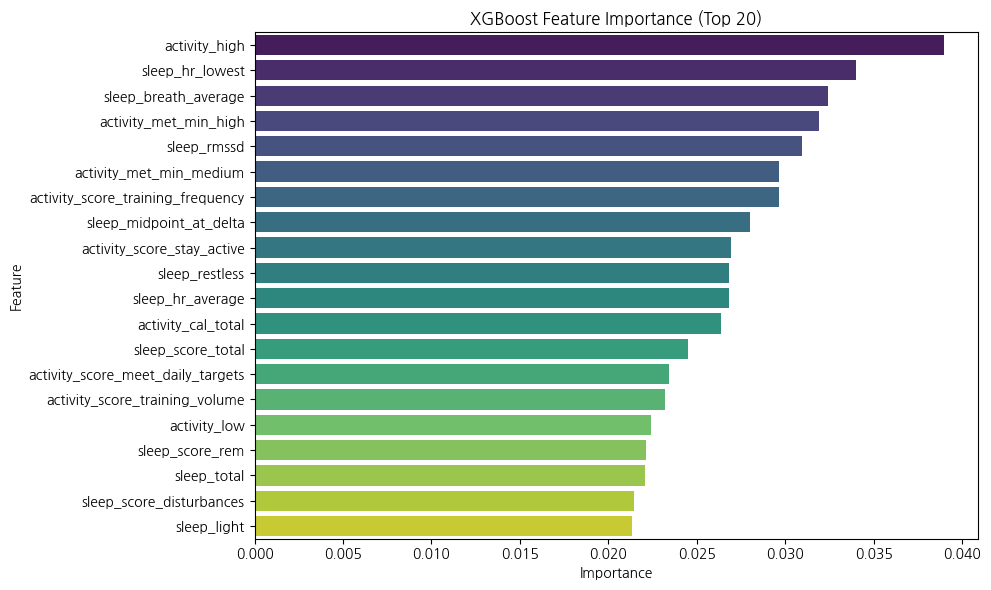

In [39]:
# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 2})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/base/train_label.csv"
train_merged = "./data/base/train_merged.csv"
test_label = "./data/base/test_label.csv"
test_merged = "./data/base/test_merged.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_merged)
test_df = load_sleep_data(test_label, test_merged)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').columns.tolist()
substrings_to_remove = ['Unnamed: 0', 'label']
numeric_cols = [col for col in numeric_cols if not any(col in sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values
stratify_y = train_df["label"].values  # label = {"CN": 0, "MCI": 1, "Dem": 2}
y = train_df["DIAG_NM"].map(lambda x: 0 if x == "CN" else 1).values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {"fold": [], "abnormal_recall": [], "abnormal_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, stratify_y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]

    model = XGBClassifier(random_state=42, eval_metric="logloss")
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    abnormal_recall = report_dict["1"]["recall"]
    abnormal_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["abnormal_recall"].append(abnormal_recall)
    metrics["abnormal_f1"].append(abnormal_f1)

    print(f"📌 Abnormal Recall: {abnormal_recall:.4f} | Abnormal F1: {abnormal_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (Abnormal only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["DIAG_NM"].map(lambda x: 0 if x == "CN" else 1).values

final_model = XGBClassifier(random_state=42, eval_metric="logloss")
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [43]:
# -------------------------
# 10. 이메일(사람) 단위 최빈 라벨 기준 평가
# -------------------------
# 테스트셋에 예측 결과 붙이기
test_df["y_true"] = y_test
test_df["y_pred"] = y_pred_test

# 이메일별로 실제 라벨과 예측 라벨의 mode 계산
from scipy.stats import mode

person_level_preds = (
    test_df.groupby("EMAIL")[["y_true", "y_pred"]]
    .agg(lambda x: mode(x).mode[0])  # 최빈값
    .reset_index()
)

# 최종 평가
print("\n📊 [사람 단위] 최빈 예측 기반 평가")
print(classification_report(person_level_preds["y_true"], person_level_preds["y_pred"], target_names=["정상", "비정상"]))


📊 [사람 단위] 최빈 예측 기반 평가
              precision    recall  f1-score   support

          정상       0.68      0.83      0.75        23
         비정상       0.56      0.36      0.43        14

    accuracy                           0.65        37
   macro avg       0.62      0.59      0.59        37
weighted avg       0.63      0.65      0.63        37



/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_85080/1369627713.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  .agg(lambda x: mode(x).mode[0])  # 최빈값


# 전처리 후 모델


🔁 Fold 1
📌 Abnormal Recall: 0.2069 | Abnormal F1: 0.2506

🔁 Fold 2
📌 Abnormal Recall: 0.1605 | Abnormal F1: 0.1893

🔁 Fold 3
📌 Abnormal Recall: 0.2443 | Abnormal F1: 0.2810

🔁 Fold 4
📌 Abnormal Recall: 0.2207 | Abnormal F1: 0.2657

🔁 Fold 5
📌 Abnormal Recall: 0.2428 | Abnormal F1: 0.2420

📊 CV Metrics Per Fold (Abnormal only):
   fold  abnormal_recall  abnoraml_f1
0     1         0.206944     0.250631
1     2         0.160458     0.189349
2     3         0.244344     0.281006
3     4         0.220674     0.265734
4     5         0.242784     0.241963

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.59      0.69      0.64      5922
         비정상       0.29      0.21      0.25      3531

    accuracy                           0.51      9453
   macro avg       0.44      0.45      0.44      9453
weighted avg       0.48      0.51      0.49      9453


📊 Test Set Evaluation
              precision    recall  f1-score   supp

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_85080/3514805713.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")


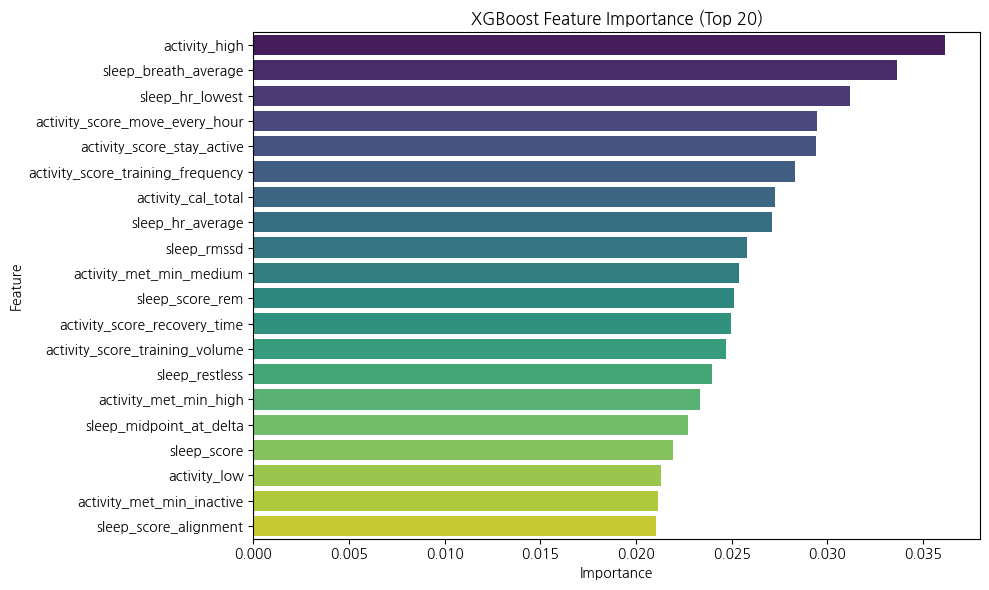

In [51]:
# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 2})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/preprocessed/train/train_label_preprocessed.csv"
train_merged = "./data/preprocessed/train/merged_preprocessed.csv"
test_label = "./data/preprocessed/validation/validation_label_preprocessed.csv"
test_merged = "./data/preprocessed/validation/merged_preprocessed.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_merged)
test_df = load_sleep_data(test_label, test_merged)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
substrings_to_remove = []
numeric_cols = [col for col in numeric_cols if not any(col == sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values
stratify_y = train_df["label"].values  # label = {"CN": 0, "MCI": 1, "Dem": 2}
y = train_df["DIAG_NM"].map(lambda x: 0 if x == "CN" else 1).values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {"fold": [], "abnormal_recall": [], "abnoraml_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, stratify_y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]

    model = XGBClassifier(random_state=42, eval_metric="logloss")
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    abnormal_recall = report_dict["1"]["recall"]
    abnoraml_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["abnormal_recall"].append(abnormal_recall)
    metrics["abnoraml_f1"].append(abnoraml_f1)

    print(f"📌 Abnormal Recall: {abnormal_recall:.4f} | Abnormal F1: {abnoraml_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (Abnormal only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["DIAG_NM"].map(lambda x: 0 if x == "CN" else 1).values

final_model = XGBClassifier(random_state=42, eval_metric="logloss")
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [50]:
# -------------------------
# 10. 이메일(사람) 단위 최빈 라벨 기준 평가
# -------------------------
# 테스트셋에 예측 결과 붙이기
test_df["y_true"] = y_test
test_df["y_pred"] = y_pred_test

# 이메일별로 실제 라벨과 예측 라벨의 mode 계산
from scipy.stats import mode

person_level_preds = (
    test_df.groupby("EMAIL")[["y_true", "y_pred"]]
    .agg(lambda x: mode(x).mode[0])  # 최빈값
    .reset_index()
)

# 최종 평가
print("\n📊 [사람 단위] 최빈 예측 기반 평가")
print(classification_report(person_level_preds["y_true"], person_level_preds["y_pred"], target_names=["정상", "비정상"]))


📊 [사람 단위] 최빈 예측 기반 평가
              precision    recall  f1-score   support

          정상       0.69      0.87      0.77        23
         비정상       0.62      0.36      0.45        14

    accuracy                           0.68        37
   macro avg       0.66      0.61      0.61        37
weighted avg       0.67      0.68      0.65        37



/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_85080/1369627713.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  .agg(lambda x: mode(x).mode[0])  # 최빈값


# 최종 개선 모델


🔁 Fold 1
📌 Abnormal Recall: 0.1875 | Abnormal F1: 0.2428

🔁 Fold 2
📌 Abnormal Recall: 0.4083 | Abnormal F1: 0.4419

🔁 Fold 3
📌 Abnormal Recall: 0.5023 | Abnormal F1: 0.4393

🔁 Fold 4
📌 Abnormal Recall: 0.4007 | Abnormal F1: 0.4337

🔁 Fold 5
📌 Abnormal Recall: 0.4194 | Abnormal F1: 0.4204

📊 CV Metrics Per Fold (Abnormal only):
   fold  Abnormal_recall  Abnormal_f1
0     1         0.187500     0.242806
1     2         0.408309     0.441860
2     3         0.502262     0.439314
3     4         0.400697     0.433690
4     5         0.419355     0.420426

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.65      0.69      0.67      5922
         비정상       0.43      0.38      0.40      3531

    accuracy                           0.58      9453
   macro avg       0.54      0.54      0.54      9453
weighted avg       0.57      0.58      0.57      9453


📊 Test Set Evaluation
              precision    recall  f1-score   supp



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



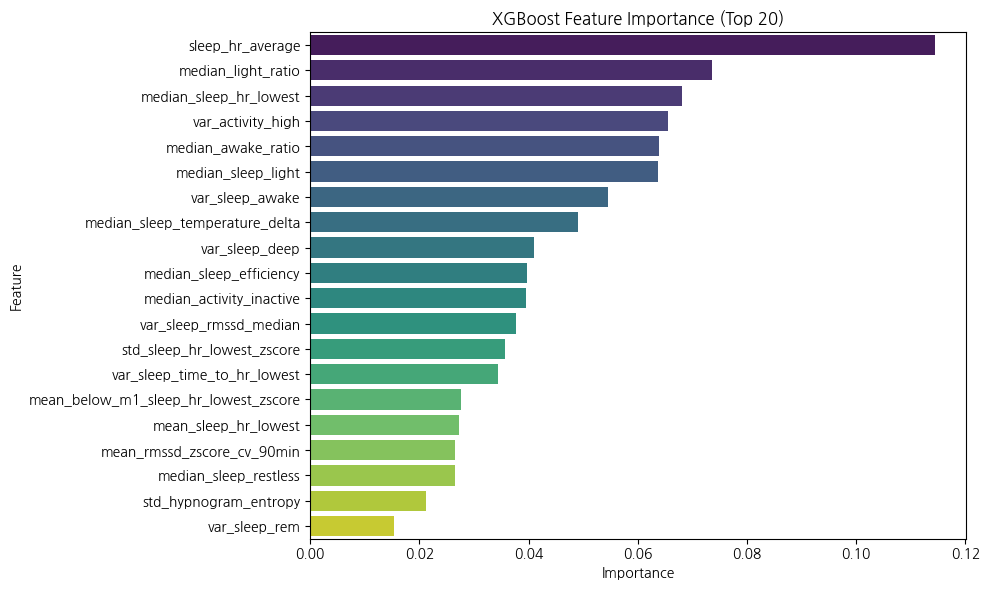

In [404]:
# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 2})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/engineered/train/train_label_engineered.csv"
train_merged = "./data/engineered/train/merged_engineered.csv"
test_label = "./data/engineered/validation/validation_label_engineered.csv"
test_merged = "./data/engineered/validation/merged_engineered.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_merged)
test_df = load_sleep_data(test_label, test_merged)

# -------------------------
# 4. 
# -------------------------
# numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()

numeric_cols = [

 'activity_high',
 'activity_inactive',
 'sleep_breath_average',
 'sleep_duration',
 'sleep_hr_average',
 'sleep_hr_lowest',
 'sleep_onset_latency',
 'sleep_score_alignment',
 'sleep_score_deep',
 'sleep_score_disturbances',
 'sleep_score_efficiency',
 'sleep_score_latency',
 'sleep_score_rem',
 'sleep_midpoint_delta_norm',
 'sleep_time_to_hr_lowest',
 'var_sleep_time_to_hr_lowest',
 'median_sleep_temperature_delta',
 'median_sleep_hr_lowest',
 'mean_sleep_hr_lowest',
 'sleep_rmssd_median',
 'sleep_rmssd_cv_90min',
 'var_sleep_rmssd_median',
 'rmssd_cv_90min_z',
 'mean_rmssd_zscore_cv_90min',
 'rmssd_median_20_70min',
 'median_sleep_efficiency',
 'var_sleep_awake',
#  'median_sleep_awake',
#  'median_sleep_deep',
#  'median_sleep_rem',
#  'awake_ratio',
#  'deep_ratio',
#  'light_ratio',
#  'rem_ratio',
 'median_deep_ratio',
 'median_rem_ratio',
 'median_awake_ratio',
 'median_light_ratio',
 'var_sleep_restless',
 'median_sleep_restless',
 'mean_sleep_restless',
 'var_sleep_rem',
 'var_sleep_deep',
 'var_sleep_light',
 'median_sleep_light',
 'sleep_startpoint_delta_norm',
 'sleep_endpoint_delta_norm',
 'median_activity_inactive',
 'median_activity_rest',
 'var_activity_high',
 'sleep_hr_lowest_zscore',
 'mean_sleep_hr_lowest_zscore',
 'std_sleep_hr_lowest_zscore',
 'median_sleep_hr_lowest_zscore',
 'pct_below_0_sleep_hr_lowest_zscore',
 'pct_below_m1_sleep_hr_lowest_zscore',
 'mean_below_m1_sleep_hr_lowest_zscore',
 'sleep_startpoint_at_delta_norm',
 'sleep_midpoint_at_delta_norm',
 'sleep_startpoint_at_delta_sin',
 'sleep_startpoint_at_delta_cos',
 'sleep_midpoint_at_delta_sin',
 'sleep_midpoint_at_delta_cos',
 'sleep_startpoint_at_delta_sin_cumsum',
 'sleep_startpoint_at_delta_cos_cumsum',
 'sleep_midpoint_at_delta_sin_cumsum',
 'sleep_midpoint_at_delta_cos_cumsum',
 'date_count',
 'sleep_consistency',
 'entropy',
 'std_hypnogram_entropy']


X = train_df[numeric_cols].values
stratify_y = train_df["label"].values  # label = {"CN": 0, "MCI": 1, "Dem": 2}
y = train_df["DIAG_NM"].map(lambda x: 0 if x == "CN" else 1).values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {"fold": [], "Abnormal_recall": [], "Abnormal_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, stratify_y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]


    model = XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        colsample_bytree=0.8,
        learning_rate=0.2,
        max_depth=7,
        n_estimators=100,
        subsample=1.0
    )
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    Abnormal_recall = report_dict["1"]["recall"]
    Abnormal_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["Abnormal_recall"].append(Abnormal_recall)
    metrics["Abnormal_f1"].append(Abnormal_f1)

    print(f"📌 Abnormal Recall: {Abnormal_recall:.4f} | Abnormal F1: {Abnormal_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (Abnormal only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["DIAG_NM"].map(lambda x: 0 if x == "CN" else 1).values

final_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0
)
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [397]:
# -------------------------
# 10. 이메일(사람) 단위 최빈 라벨 기준 평가
# -------------------------
# 테스트셋에 예측 결과 붙이기
test_df["y_true"] = y_test
test_df["y_pred"] = y_pred_test

# 이메일별로 실제 라벨과 예측 라벨의 mode 계산
from scipy.stats import mode

person_level_preds = (
    test_df.groupby("EMAIL")[["y_true", "y_pred"]]
    .agg(lambda x: mode(x).mode[0])  # 최빈값
    .reset_index()
)

# 최종 평가
print("\n📊 [사람 단위] 최빈 예측 기반 평가")
print(classification_report(person_level_preds["y_true"], person_level_preds["y_pred"], target_names=["정상", "비정상"]))


📊 [사람 단위] 최빈 예측 기반 평가
              precision    recall  f1-score   support

          정상       0.80      0.70      0.74        23
         비정상       0.59      0.71      0.65        14

    accuracy                           0.70        37
   macro avg       0.69      0.70      0.69        37
weighted avg       0.72      0.70      0.71        37



Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


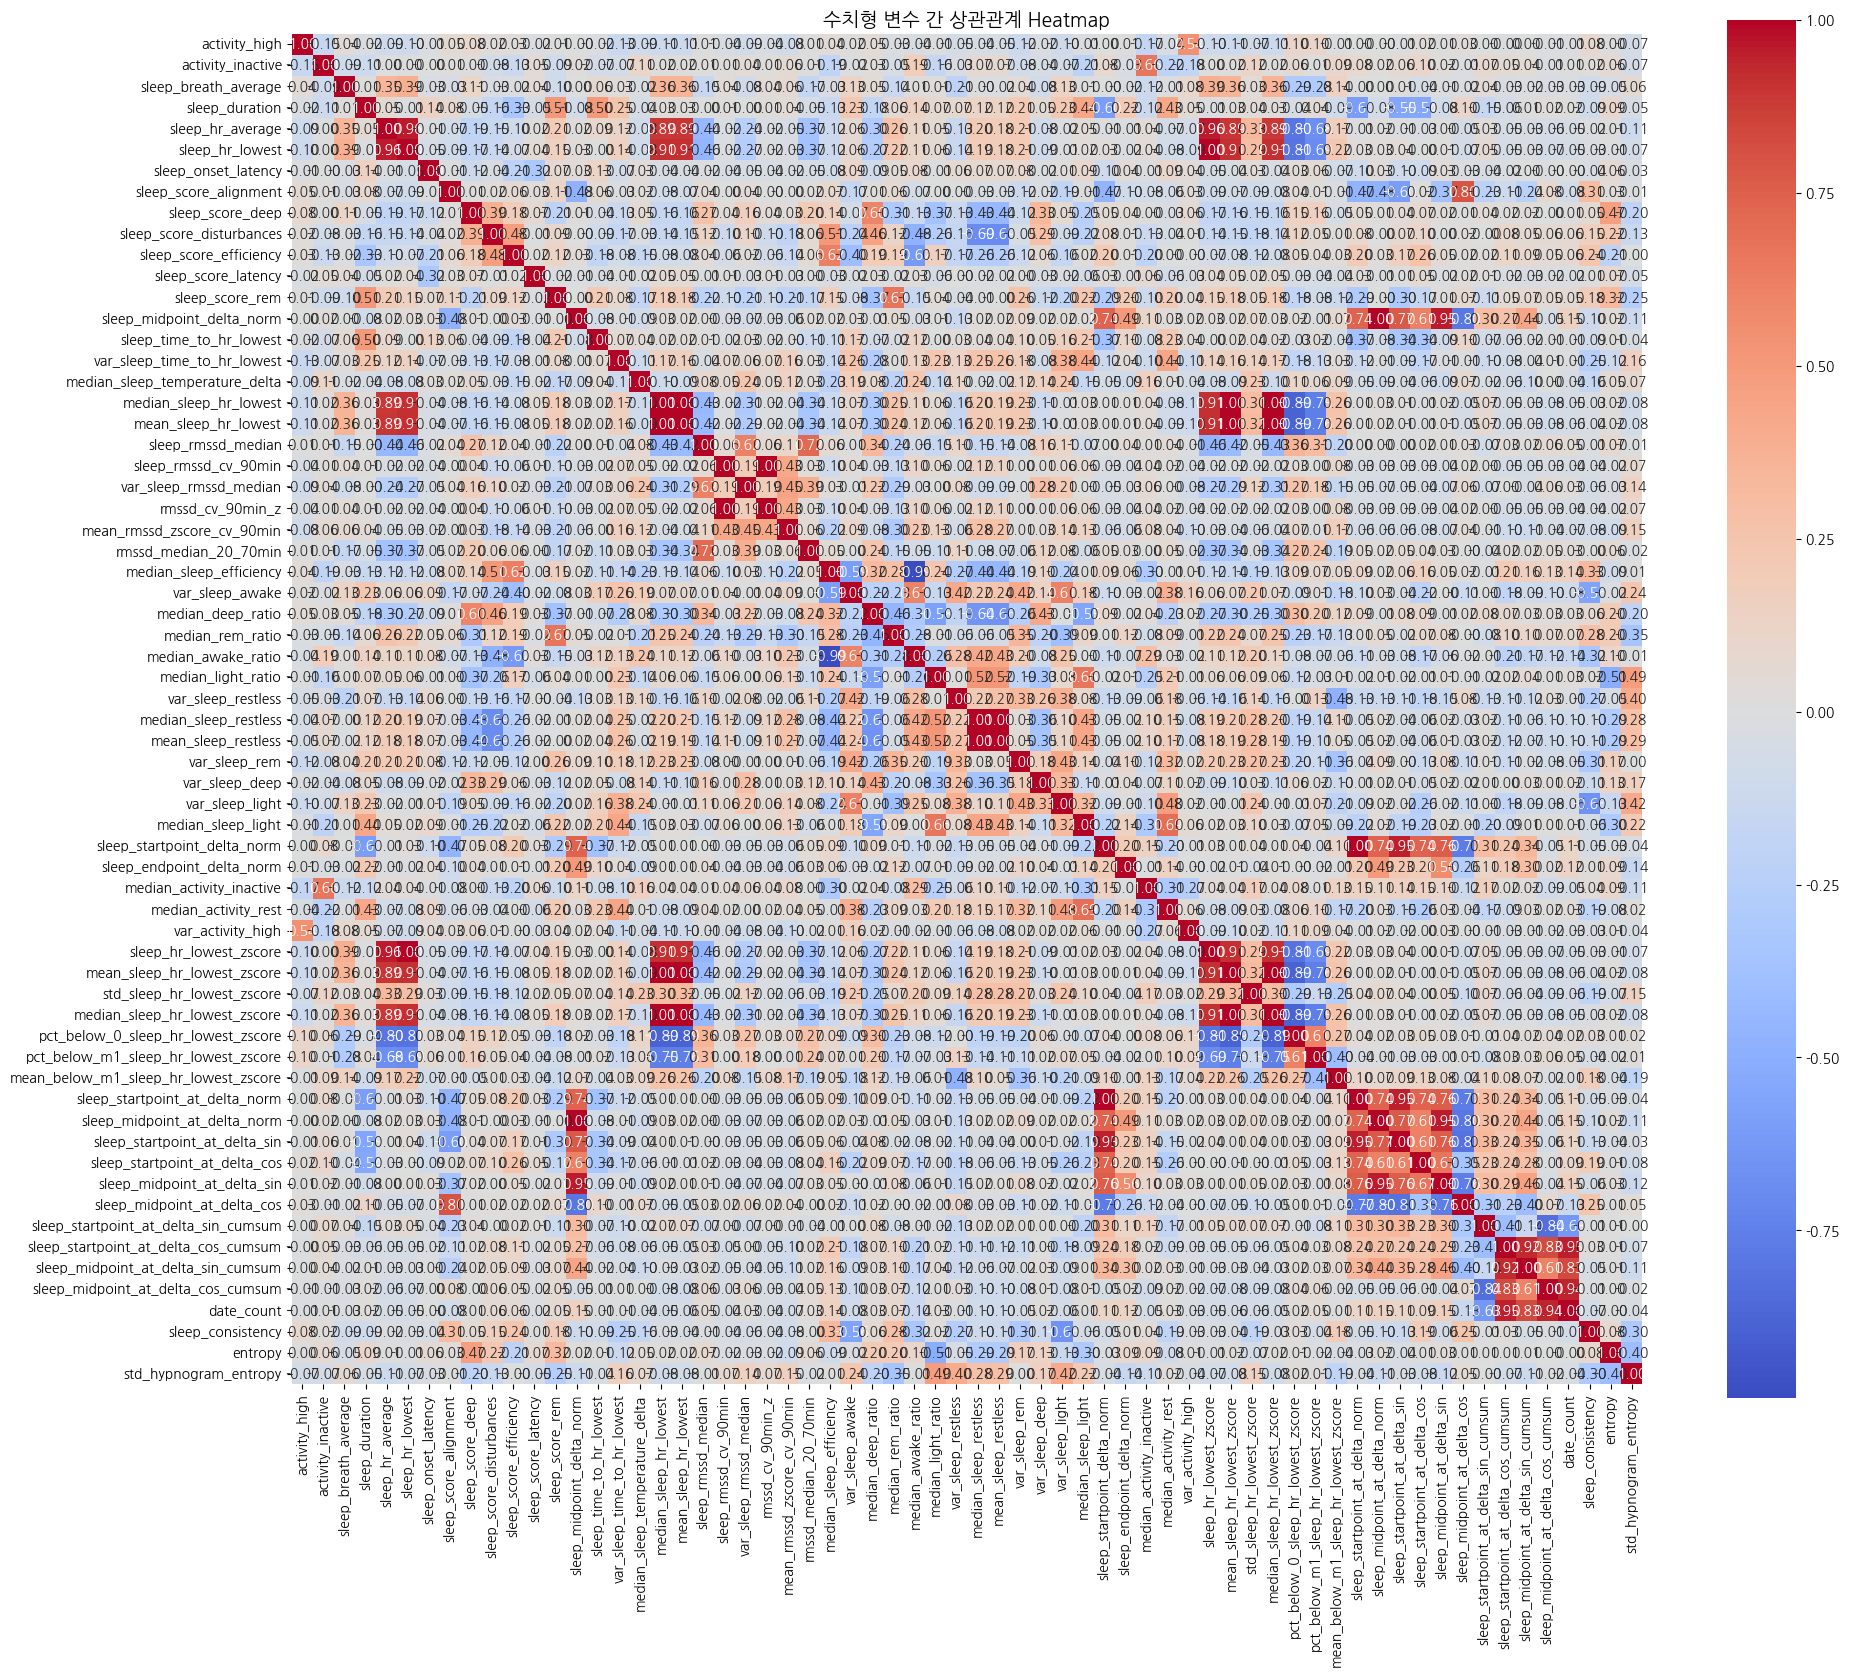

In [399]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    train_df[numeric_cols].corr(),
    annot=True,             # 🔹 어노테이션 표시
    fmt=".2f",              # 🔹 소수점 2자리 표시
    cmap="coolwarm",        # 🔹 컬러맵 설정
    square=True,            # 🔹 정사각형 셀
    cbar_kws={"shrink": 0.75}  # 🔹 컬러바 축소
)
plt.title("수치형 변수 간 상관관계 Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

# 하이퍼파라미터 튜닝

In [401]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

# -------------------------
# 1. 파라미터 후보 정의
# -------------------------
param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

# -------------------------
# 2. 파이프라인 구성
# -------------------------
pipeline = Pipeline([
    ("xgb", XGBClassifier(random_state=42, eval_metric="logloss"))
])

f1_positive_scorer = make_scorer(f1_score, pos_label=1)

# -------------------------
# 3. CV 구성 및 GridSearch
# -------------------------
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=f1_positive_scorer,
    cv=group_kfold.split(X_scaled, y, groups),
    verbose=1,
    n_jobs=-1
)

# -------------------------
# 4. 학습 및 최적 파라미터 확인
# -------------------------
grid_search.fit(X_scaled, y)
print("\n✅ Best Parameters:")
print(grid_search.best_params_)

print("\n🏆 Best CV F1 Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best Parameters:
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}

🏆 Best CV F1 Score:
0.4059120981432347
